<a href="https://colab.research.google.com/github/cavrudy/Crypto-Prediction-Model/blob/main/crypto_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics



In [189]:
indicators = ['RSI', 'MACD']

In [190]:

def ticker_data(days, timeframe, ticker):
    start = (datetime.date.today() - datetime.timedelta(days))
    end = datetime.datetime.today()

    # Loading start, end time, and interval into YF package
    ticker_data = yf.download(ticker, start=start, end=end, interval=timeframe)
    ticker_data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)

    return ticker_data.head()
    

data = ticker_data(10, '1d', 'SPY')
data


[*********************100%***********************]  1 of 1 completed


,open,high,low,close,Adj Close,volume
Date,,,,,,
2022-06-29,381.230011,382.269989,378.420013,380.339996,380.339996,65676000
2022-06-30,376.239990,380.660004,372.559998,377.250000,377.250000,112508300
2022-07-01,376.559998,381.700012,373.799988,381.239990,381.239990,74792100
2022-07-05,375.880005,381.980011,372.899994,381.959991,381.959991,81438000
2022-07-06,382.109985,385.869995,379.600006,383.250000,383.250000,70426200


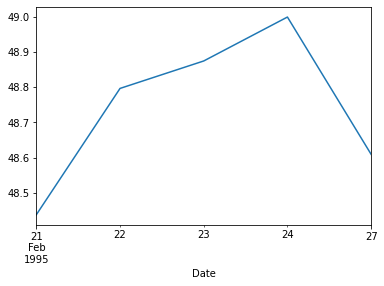

In [141]:
tmp = data.iloc[-60:]
tmp['close'].plot()

In [191]:
def exponential_weight(data, alpha):
  # Exponential weight collects more accurate float integers
  return data.ewm(alpha=alpha).mean()

exp_weight = exponential_weight(data, 0.65)

exp_weight.head()

,open,high,low,close,Adj Close,volume
Date,,,,,,
2022-06-29,381.230011,382.269989,378.420013,380.339996,380.339996,6.567600e+07
2022-06-30,377.533699,381.077407,374.079261,378.051110,378.051110,1.003666e+08
2022-07-01,376.872442,381.500229,373.889602,380.216733,380.216733,8.299852e+07
2022-07-05,376.217530,381.816838,373.236557,381.367114,381.367114,8.196873e+07
2022-07-06,380.067849,384.465300,377.394638,382.597452,382.597452,7.442647e+07


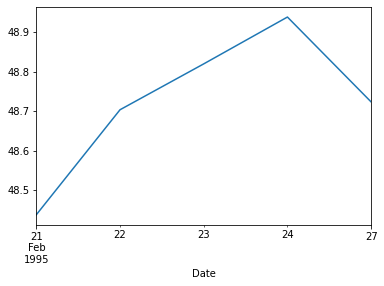

In [144]:
tmp1 = exp_weight.iloc[-60:]
tmp1['close'].plot()

In [192]:
def indicator_data(data):

  for indicator in indicators:
    ind_data = eval('TA.' + indicator + '(exp_weight)')
    #if not isinstance(ind_data, pd.DataFrame):
        #ind_data = ind_data.to_frame()
    data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period RSI": 'RSI 14', "14 period STOCH %K": 'STOCH 14'}, inplace=True)

    # Also calculate moving averages for features
  data['ema200'] = data['close'] / data['close'].ewm(200).mean()
  data['ema50'] = data['close'] / data['close'].ewm(50).mean()
  data['ema20'] = data['close'] / data['close'].ewm(20).mean()
  data['ema9'] = data['close'] / data['close'].ewm(9).mean()

  # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
  data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

  # Remove columns that won't be used as features
  data.drop(['open', 'high', 'low', 'Adj Close', 'volume'], axis=1, inplace=True)
    
  return data

indicator_data = indicator_data(exp_weight)
indicator_data

,close,RSI 14,MACD,SIGNAL,ema200,ema50,ema20,ema9,normVol
Date,,,,,,,,,
2022-06-29,380.339996,NaN,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-06-30,378.051110,0.000000,-0.051353,-0.028530,0.996989,0.997012,0.997055,0.997140,1.186392
2022-07-01,380.216733,50.468756,0.001722,-0.016132,1.001794,1.001796,1.001797,1.001798,0.988486
2022-07-05,381.367114,61.565335,0.067353,0.012149,1.003606,1.003579,1.003527,1.003420,0.983751
2022-07-06,382.597452,69.448634,0.150556,0.053322,1.005453,1.005392,1.005269,1.005023,0.920622


In [166]:
live_pred_data = indicator_data.iloc[0: 6]
